In [1]:
include("../src/PowerPhaseRetrieval.jl")
import PowerModels as PM
import .PowerPhaseRetrieval as PPR
using JuMP,Ipopt
using LinearAlgebra,Random,Statistics
using Plots,LaTeXStrings

[info | PowerModels]: Suppressing information and warning messages for the rest of this session.  Use the Memento package for more fine-grained control of logging.


┌ Warning: Replacing docs for `Main.PowerPhaseRetrieval.compute_basic_ac_pf! :: Tuple{Dict{String, Any}}` in module `Main.PowerPhaseRetrieval`
└ @ Base.Docs docs/Docs.jl:240
┌ Warning: Replacing docs for `Main.PowerPhaseRetrieval.calc_closest_rank_r :: Tuple{Matrix, Integer}` in module `Main.PowerPhaseRetrieval`
└ @ Base.Docs docs/Docs.jl:240
┌ Warning: Replacing docs for `Main.PowerPhaseRetrieval.calc_closest_rank_r :: Tuple{Matrix, Integer}` in module `Main.PowerPhaseRetrieval`
└ @ Base.Docs docs/Docs.jl:240


In [2]:
function is_gershdisc_invertible(A::AbstractMatrix)
    n = size(A)[1]
    lhs,rhs = [],[]
    for i=1:n
        push!(lhs,abs(A[i,i]))
        push!(rhs,sum([abs(A[k,i]) for k=1:n if k != i]))
    end
    return all(lhs .> rhs)
end

is_gershdisc_invertible (generic function with 1 method)

In [36]:
function is_diagonally_dominant(A::AbstractMatrix)
    n = size(A)[1]
    is = true
    for i=1:n
        if sum([abs(A[k,i]) for k=1:n if k != i]) > abs(A[i,i])
            is = false
        end    
    end
    return is
end

row_offdiag_sum(A) = [sum([abs(A[k,i]) for k=1:size(A)[1] if k != i]) for i=1:size(A)[1]]
col_offdiag_sum(A) = [sum([abs(A[i,k]) for k=1:size(A)[1] if k != i]) for i=1:size(A)[1]]

col_offdiag_sum (generic function with 1 method)

In [50]:
"""
Struct for the Δθ observability condition in Theorem 1.
"""
struct PhaseObservability
    lhs::Vector{Float64}
    rhs_row::Vector{Float64}
    rhs_col::Vector{Float64}
    observable::Vector{Bool}
end

function calc_phase_observability(net::Dict;sel_bus_types =[1])
    sel_bus_idx = PPR.calc_bus_idx_of_type(net,sel_bus_types)
    n_bus = length(sel_bus_idx)
    J = PPR.calc_jacobian_matrix(net)
    v = abs.(PM.calc_basic_bus_voltage(net))[sel_bus_idx]
    q = imag.(PM.calc_basic_bus_injection(net))[sel_bus_idx]
    Sqv = J.qv[sel_bus_idx,sel_bus_idx]
    @assert length(v) == length(q) == size(Sqv)[1] == size(Sqv)[2]
    rhs_col,rhs_row = [],[]
    lhs,observable = [],[]
    for i = 1:n_bus
        push!(lhs,
            abs(-v[i]*Sqv[i,i] +2*q[i]) + abs(Sqv[i,i])
        )
        push!(rhs_row,
            #sum([(1+v[k])*abs(Sqv[i,k]) for k =1:n_bus if k!=i])
            (1 + v[i])*sum([abs(Sqv[k,i]) for k=1:n_bus if k != i])
        )
        push!(rhs_col,
            sum([(1+v[k])*abs(Sqv[i,k]) for k =1:n_bus if k!=i])
        )
        push!(observable,
            (lhs[i] >= rhs_row[i]) || (lhs[i] >= rhs_col[i])
        )
    end
    return PhaseObservability(
        lhs,rhs_row,rhs_col,observable
    )
end

function calc_phase_observability!(net::Dict) 
    PM.compute_ac_pf!(net) 
    return calc_phase_observability(net)
end

calc_phase_observability! (generic function with 1 method)

In [73]:
net = PM.make_basic_network(PM.parse_file("/home/sam/research/PowerPhaseRetrieval.jl/data/case_RTS_GMLC.m"))
PM.compute_ac_pf!(net)
Jmodel = PPR.calc_jacobian_matrix(net,[1])
J = Matrix(Jmodel.matrix)
Spth,Sqv = Matrix(Jmodel.pth),Matrix(Jmodel.qv)
Sqth,Spv = Matrix(Jmodel.qth),Matrix(Jmodel.pv)
println(is_gershdisc_invertible(J))
println(is_gershdisc_invertible(Spth))
println(is_gershdisc_invertible(Sqv))
println(is_gershdisc_invertible(Sqv - Sqth*inv(Spth)*Spv))

false
true
false
false


13-element Vector{Float64}:
 18.542863606949332
  8.66015263350249
 10.46466454130438
 15.224763672939172
 10.82921395695281
 44.64589737015455
 55.4128982923532
 22.74333196981776
 22.539296232183638
  0.0
 49.166293290202844
 49.508360550563076
 10.939812988931518

In [58]:
ph_obs = calc_phase_observability(net,sel_bus_types=[1])

PhaseObservability([44.53758079459899, 31.289004817101038, 42.56981064779547, 39.62385685244243, 50.517936255900295, 87.08149568643816, 107.69798371462797, 132.25797730497726, 104.90466229905243, 230.77086746274682, 181.9777510158135, 279.0178361517683, 57.927621581026344], [36.4985288859081, 17.579364525822047, 21.199928603461892, 31.558865308432082, 22.36787170706109, 87.59376116931705, 107.84385016320046, 45.177927958482655, 44.92465390713413, 0.0, 98.60183527801624, 98.07455392351217, 21.32311514576247], [36.480119715657864, 17.133173071229383, 20.958272107379806, 30.491635787136058, 21.557170777272788, 88.0750158119958, 109.73570231735076, 45.27328539178144, 44.86706962782262, 0.0, 98.07455392351217, 98.60183527801624, 21.49642276695544], Bool[1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1])

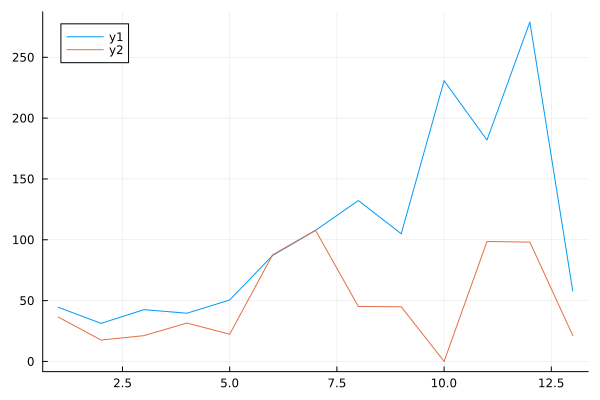

In [60]:
plot(ph_obs.lhs)
plot!(ph_obs.rhs_row)
#plot!(ph_obs.rhs_col)

In [61]:
sum(ph_obs.observable)/length(ph_obs.observable)

0.8461538461538461

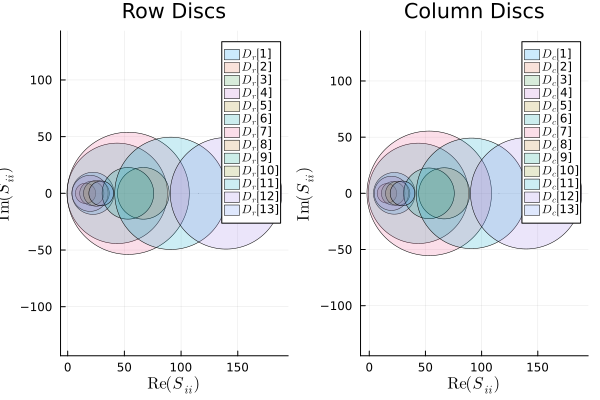

In [63]:
PPR.plot_gershdisc(Sqv)